In [1]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_numeric, strip_punctuation, strip_short, stem_text
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess 10-K filings

In [3]:
data_by_year = {}
# Filing_Date is included because its (allegedly) useful for matching with the predictions. Also useful for 
# deciding what 1a/7 text is correct (by newness)
relevant_cols = ["cik", "ticker", "filing_date", "item1a_risk", "item7_mda"]
path = "../Files/"
figs_path = './figs/'

# Only load ^ columns. Drop if N/A in cik, item1a, or item7 or if duplicate. Append year
for year in range(2009,2021):
    data_by_year[year] = pd.read_csv(path + str(year) + ".csv", usecols=relevant_cols)
    data_by_year[year] = data_by_year[year].dropna(subset=['cik', 'item1a_risk', 'item7_mda']).drop_duplicates()
    data_by_year[year]["filing_date"] = pd.to_datetime(data_by_year[year]["filing_date"])
    data_by_year[year]["year"] = year
    data_by_year[year]["filing_year"] =  pd.DatetimeIndex(data_by_year[year]["filing_date"]).year

In [4]:
# Dirty logic for collapsing groups. Reformat as needed - currently pretty dumb
def collapse_cik_groups(grp):
    if len(grp) > 1:
        """ If the 1a and 7 text is the same, take the most recent (regardless of ticker)"""
        if (grp.iloc[0,3] == grp["item1a_risk"]).all() and (grp.iloc[0,3] == grp["item7_mda"]).all():
            # Seems like its sorted by filing_date originally - just take the last
            return grp.iloc[-1,:]
        else:
            """For now, just return the most recent"""
            return grp.iloc[-1,:]
    else:
        return grp.squeeze()

pre_grouping_sizes = []
post_grouping_sizes = []

for year in range(2009,2021):
    pre_grouping_sizes.append(len(data_by_year[year]))
    data_by_year[year] = data_by_year[year].groupby("cik").apply(lambda grp: collapse_cik_groups(grp)).reset_index(drop=True)
    post_grouping_sizes.append(len(data_by_year[year])) 

In [5]:
for pre_size, post_size, year in zip(pre_grouping_sizes, post_grouping_sizes, list(range(2009,2021))):
    num_lost = pre_size - post_size
    percent_lost = float(num_lost) / float(pre_size)
    display("{:n} lost {:.0%}, {} rows total".format(year, percent_lost, num_lost))

num_lost = sum(pre_grouping_sizes) - sum(post_grouping_sizes)
percent_lost = float(num_lost) / float(sum(pre_grouping_sizes))
display("In total lost {:.0%}, {} rows total".format(percent_lost, num_lost))

'2009 lost 2%, 14 rows total'

'2010 lost 2%, 51 rows total'

'2011 lost 2%, 58 rows total'

'2012 lost 2%, 56 rows total'

'2013 lost 2%, 60 rows total'

'2014 lost 2%, 68 rows total'

'2015 lost 2%, 76 rows total'

'2016 lost 2%, 73 rows total'

'2017 lost 2%, 83 rows total'

'2018 lost 2%, 86 rows total'

'2019 lost 3%, 87 rows total'

'2020 lost 3%, 62 rows total'

'In total lost 2%, 774 rows total'

In [6]:
# Concat all dataframes into a single one
text_dfs = pd.concat(data_by_year.values(), ignore_index=True)
text_dfs

,cik,ticker,filing_date,item1a_risk,item7_mda,year,filing_year
0,1750,AIR,2009-07-16,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
1,2034,ACET,2009-09-11,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2009,2009
2,2491,BYI,2009-08-20,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
3,2969,APD,2009-11-25,>ITEM 1A. RISK FACTORS The Company operates in...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
4,3545,ALCO,2009-12-14,>Item 1A. Risk Factors. Alico s operations inv...,>Item 7. Management s Discussion and Analysis ...,2009,2009
...,...,...,...,...,...,...,...
36346,1796129,LSACU,2020-09-23,>ITEM 1A. RISK FACTORS 13,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2020,2020
36347,1796587,NO_TICKER,2020-05-21,>Item 1A.Risk Factors.Item 2.Properties.,>Item 7.Management's Discussion and Analysis o...,2020,2020
36348,1797956,CPOW,2020-08-11,>Item 1A. Risk Factors. We discuss our expecta...,>Item 7. Management s Discussion and Analysis ...,2020,2020
36349,1799186,NONE,2020-06-25,">Item 1A, Risk Factors (c) Item 2, Properties ...",">Item 7, Management s Discussion and Analysis ...",2020,2020


# Load target data

In [6]:
# Load predictions

relevant_cols = ["PERMID", "CIK", "Ticker", "year", "FilingDate", "company_name", "Dividend Payer", "DPS growth", "DPS cut", "zEnvironmental", "dEnvironmental", "sector"]
predictions = pd.read_excel(path + "predictions.xlsx", sheet_name="data", skiprows=32, usecols=relevant_cols)
predictions.columns = ["perm_id", "cik", "ticker", "year", "filing_date", "company_name", "is_dividend_payer", "dps_change", "is_dps_cut", "z_environmental", "d_environmental", "sector"]
predictions['perm_id'] = predictions['perm_id'].str.replace(r"[^0-9]",'')
predictions["filing_date"] = pd.to_datetime(predictions["filing_date"])
predictions["filing_year"] = pd.DatetimeIndex(predictions["filing_date"]).year

""" Difference in filing_date and the year (ticker AA  has 2016 w/ 2017 filing)"""
predictions

<ipython-input-8-0d36a008026f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  predictions['perm_id'] = predictions['perm_id'].str.replace(r"[^0-9]",'')


,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year
0,229,1090872,A,2012,2012-12-20,AGILENT TECHNOLOGIES INC,1.0,0.421053,0.0,2.449925,-1.408006,Health Care,2012
1,229,1090872,A,2013,2013-12-19,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,1.666993,1.117957,Health Care,2013
2,229,1090872,A,2014,2014-12-22,AGILENT TECHNOLOGIES INC,1.0,-0.275862,1.0,2.154238,-0.193752,Health Care,2014
3,229,1090872,A,2015,2015-12-21,AGILENT TECHNOLOGIES INC,1.0,0.139535,0.0,2.069083,0.039619,Health Care,2015
4,229,1090872,A,2016,2016-12-20,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,2.087030,-0.112717,Health Care,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27030,3286,1011006,YHOO,2015,2016-02-29,ALTABA INC,0.0,NaN,NaN,-0.180481,-1.653875,Consumer,2016
27031,3286,1011006,YHOO,2016,2017-03-01,ALTABA INC,0.0,NaN,NaN,-0.836055,NaN,Consumer,2017
27032,2000,887568,ZOLL,2010,2010-12-17,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2010
27033,2000,887568,ZOLL,2011,2011-11-23,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2011


In [7]:
pred_ciks = set(predictions.cik.unique())
text_ciks = set(text_dfs.cik.unique())

intersection = pred_ciks.intersection(text_ciks)
text_only = text_ciks.difference(pred_ciks)
pred_only = pred_ciks.difference(text_ciks)

In [8]:
display(len(intersection))
display(len(text_only))
display(len(pred_only))

4645

595

22

In [9]:
common_ciks = sorted(list(intersection))

In [10]:
predictions = predictions[predictions.filing_year > 2011]
text_dfs = text_dfs[text_dfs.year > 2011]

In [13]:
valid_10ks = []
valid_metrics = []

year_to_ind = {
    2009:0,
    2010:1,
    2011:2,
    2012:3,
    2013:4,
    2014:5,
    2015:6,
    2016:7,
    2017:8,
    2018:9,
    2019:10,
    2020:11
}

for cik in common_ciks:
    text_binary = [0] * 9
    text_years = text_dfs[text_dfs.cik == cik].year
    for year in text_years:
        text_binary[year_to_ind[year] - 3] = 1
    valid_10ks.append(text_binary)
        
    
    pred_binary = [0] * 9
    pred_years = predictions[predictions.cik == cik].filing_year
    for year in pred_years:
        pred_binary[year_to_ind[year] - 3] = 1
    valid_metrics.append(pred_binary)
        


binary_10k = np.array(valid_10ks)
binary_metrics = np.array(valid_metrics)
binary_both = np.logical_and(binary_10k, binary_metrics)

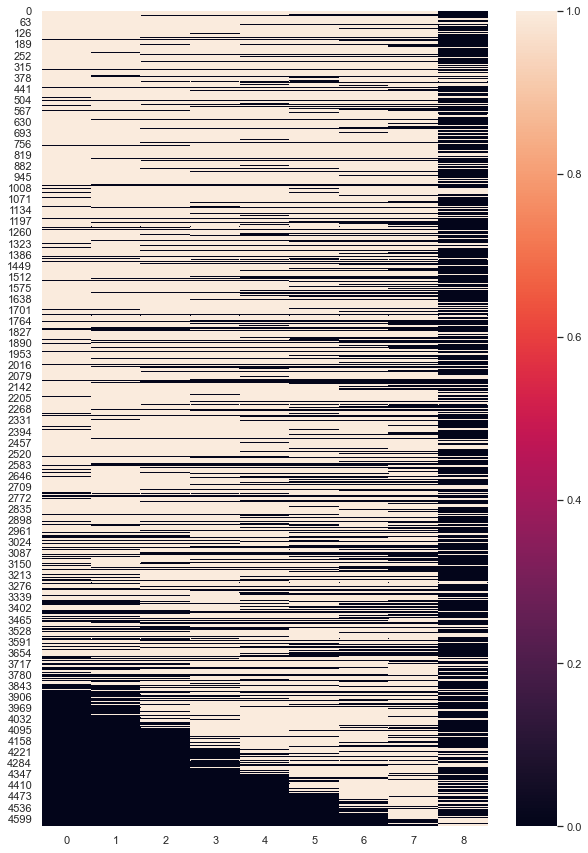

In [19]:
sns.set(rc={'figure.figsize':(10,15)})

sns.heatmap(binary_10k)
plt.savefig(figs_path + "10KHeatmap.jpg")

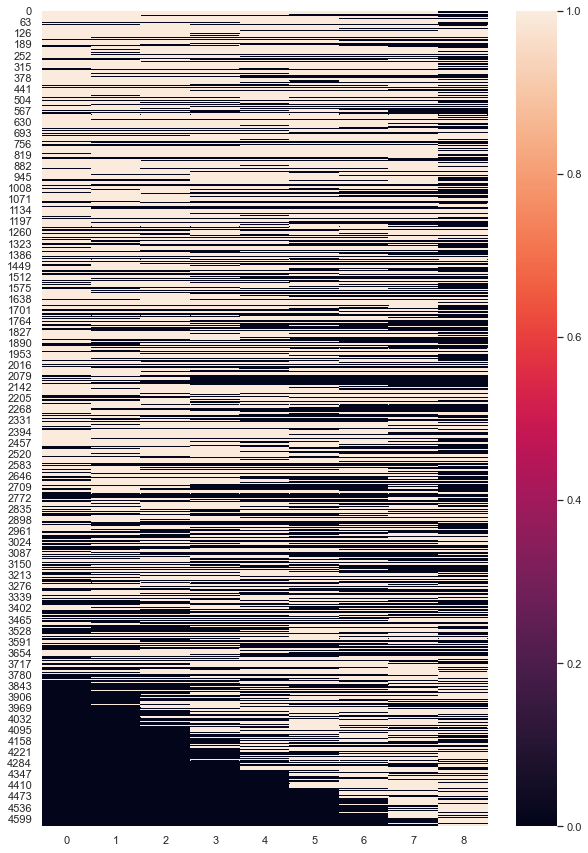

In [20]:
sns.heatmap(binary_metrics)
plt.savefig(figs_path + "MetricHeatmap.jpg")

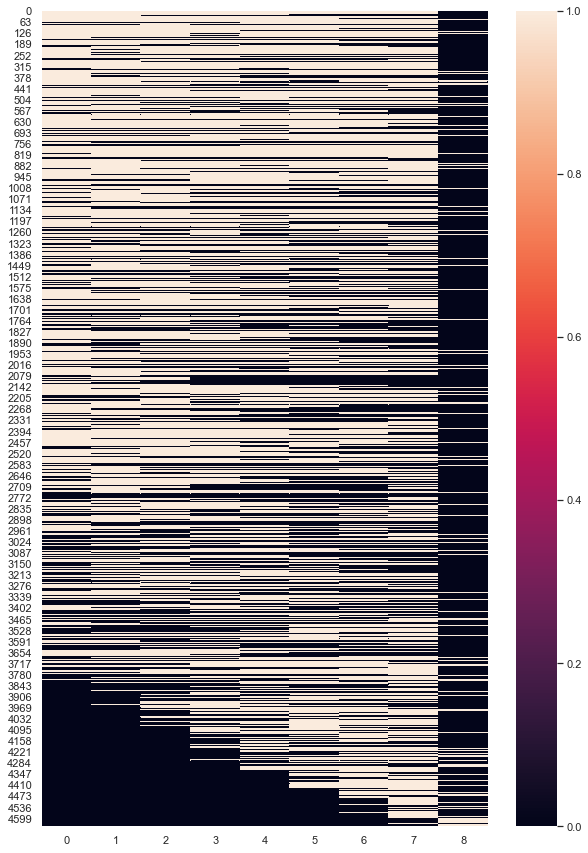

In [21]:
sns.heatmap(binary_both)
plt.savefig(figs_path + "BothHeatmap.jpg")

In [22]:
binary_both.sum() / float(binary_both.size)

0.5236694175337878

In [23]:
xclusive_and = binary_metrics == binary_10k
xclusive_and.sum() / float(xclusive_and.size)

0.8192082286807798

In [24]:
binary_10k

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [25]:
common_ciks

[1750,
 1800,
 2034,
 2178,
 2488,
 2491,
 2969,
 3116,
 3197,
 3453,
 3499,
 3545,
 3570,
 4127,
 4281,
 4447,
 4457,
 4904,
 4962,
 4977,
 5133,
 5272,
 5513,
 5768,
 5981,
 6176,
 6201,
 6281,
 6284,
 6314,
 6769,
 6845,
 6885,
 6951,
 6955,
 7039,
 7084,
 7332,
 7431,
 7536,
 7789,
 8063,
 8411,
 8670,
 8818,
 8858,
 8868,
 8947,
 9092,
 9263,
 9326,
 9346,
 9389,
 9892,
 9984,
 10254,
 10329,
 10456,
 10795,
 11199,
 11544,
 12208,
 12659,
 12927,
 12978,
 14177,
 14195,
 14272,
 14693,
 14707,
 14846,
 14930,
 15615,
 16040,
 16058,
 16099,
 16160,
 16732,
 16918,
 17313,
 17485,
 17843,
 18061,
 18169,
 18172,
 18230,
 18255,
 18349,
 18396,
 18498,
 18808,
 18926,
 18937,
 19411,
 19446,
 19584,
 19612,
 19617,
 19745,
 20212,
 20286,
 20520,
 20629,
 20740,
 21076,
 21175,
 21344,
 21510,
 21535,
 21665,
 22444,
 22701,
 23082,
 23111,
 23194,
 23197,
 23217,
 23666,
 23675,
 23795,
 24090,
 24491,
 24545,
 24741,
 25212,
 25232,
 25354,
 25445,
 25475,
 25743,
 25793,
 26058,

In [26]:
predictions[predictions.year == 1090872]

,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year


In [27]:
text_dfs[text_dfs.cik == 1090872]

,cik,ticker,filing_date,item1a_risk,item7_mda,year,filing_year
9365,1090872,A,2012-12-20,">Item 1A. Risk Factors Risks, Uncertainties an...",>Item 7. Management's Discussion and Analysis ...,2012,2012
12634,1090872,A,2013-12-19,">ITEM 1A. RISK FACTORS Risks, Uncertainties an...",>Item 7. Management's Discussion and Analysis ...,2013,2013
15944,1090872,A,2014-12-22,">ITEM 1A. RISK FACTORS Risks, Uncertainties an...",>Item 7. Management's Discussion and Analysis ...,2014,2014
19331,1090872,A,2015-12-21,">ITEM 1A. RISK FACTORS Risks, Uncertainties an...",>Item 7. Management's Discussion and Analysis ...,2015,2015
22782,1090872,A,2016-12-20,>ITEM 1A. RISK FACTORS Our operating results a...,>Item 7. Management's Discussion and Analysis ...,2016,2016
26199,1090872,A,2017-12-21,>ITEM 1A. RISK FACTORS Our operating results a...,>Item 7. Management's Discussion and Analysis ...,2017,2017
29557,1090872,A,2018-12-20,>Item 1A. Risk Factors Our operating results a...,>Item 7. Management's Discussion and Analysis ...,2018,2018
32897,1090872,A,2019-12-19,">Item 1A. Risk FactorsRisks, Uncertainties and...",>Item 7. Management's Discussion and Analysis ...,2019,2019


# Merge Data, Write to disk

In [28]:
num_pred = float(len(predictions))
num_text = float(len(text_dfs))

In [29]:
result = pd.merge(text_dfs, predictions, on=["cik", "filing_date"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (7248,25%)'

'# and % of stock events lost: (1945,8%)'

'# and % of ticker mismatches: (535,2%)'

In [30]:
result = pd.merge(text_dfs, predictions, on=["cik", "filing_year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (7224,25%)'

'# and % of stock events lost: (1921,8%)'

'# and % of ticker mismatches: (536,2%)'

'# and % of filing date mismatches: (24,0%)'

'# and % of ticker and filing date mismatches: (1,0%)'

'# and % of ticker or filing date mismatches: (559,3%)'

In [31]:
result[filing_date_mismatch]

,cik,ticker_x,filing_date_x,item1a_risk,item7_mda,year_x,filing_year,perm_id,ticker_y,year_y,filing_date_y,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector
588,718789,SHFL,2012-12-21,>ITEM 1A. RISK FACTORS RISKS RELATED TO OUR BU...,>ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS ...,2012,2012,40,SHFL,2011,2012-01-05,SHFL ENTERTAINMENT INC,0.0,NaN,NaN,NaN,NaN,Industrials
1782,1099941,MVC,2012-01-12,>Item 1A. RISK FACTORS Investing in MVC Capita...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2012,2012,4564,MVC,2012,2012-12-27,MVC CAPITAL INC,1.0,0.086957,0.0,0.580647,-0.279010,Financials
3786,914712,MLNK,2013-10-15,>ITEM 1A. RISK FACTORS We operate in a rapidl...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS...,2013,2013,619,MLNK,2012,2013-01-11,STEEL CONNECT INC,0.0,NaN,NaN,NaN,NaN,Tech
4971,1409493,CIM,2013-03-08,>Item 1A. Risk Factors If any of the following...,>Item 7. Management's Discussion and Analysis ...,2013,2013,3610,CIM,2012,2013-12-31,CHIMERA INVESTMENT CORP,1.0,0.000000,0.0,-0.597933,-0.279010,Financials
5046,1457543,CFN,2013-01-31,>ITEM 1A. RISK FACTORS We urge you to carefull...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2013,2013,3682,CFN,2013,2013-08-09,CAREFUSION CORP,0.0,NaN,NaN,0.346984,-0.011039,Health Care
5153,1504747,SWSH,2013-02-26,">ITEM 1A. RISK FACTORS. Our business, financia...",>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2013,2013,1417,SWSH,2012,2013-05-01,SWISHER HYGIENE INC,0.0,NaN,NaN,0.947447,NaN,Consumer
5955,790703,TECD,2014-02-05,>ITEM 1A. Risk Factors. The following are cert...,>ITEM 7.Management s Discussion and Analysis o...,2014,2014,157,TECD,2014,2014-04-09,TECH DATA CORP,0.0,NaN,NaN,-0.391493,-0.476001,Tech
6391,913760,INTL,2014-01-15,>Item 1A. Risk FactorsWe face a variety of ris...,>Item 7. Management s Discussion and Analysis ...,2014,2014,3729,INTL,2014,2014-12-10,STONEX GROUP INC,0.0,NaN,NaN,-0.622346,3.287319,Financials
7023,1129633,PNX,2014-08-06,>Item 1A. Risk FactorsRisks Related to the Res...,>Item 7. Management s Discussion and Analysis ...,2014,2014,3618,PNX,2012,2014-04-01,PHOENIX COMPANIES INC,0.0,NaN,NaN,NaN,NaN,Financials
8108,43920,GEF,2015-12-21,>ITEM 1A. RISK FACTORS Statements contained in...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2015,2015,1113,GEF,2014,2015-01-21,GREIF INC -CL A,1.0,0.000000,0.0,2.496798,0.088497,Commodities


In [32]:
result = pd.merge(text_dfs, predictions, left_on=["cik", "year"], right_on=["cik", "filing_year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (7224,25%)'

'# and % of stock events lost: (1921,8%)'

'# and % of ticker mismatches: (536,2%)'

'# and % of filing date mismatches: (24,0%)'

'# and % of ticker and filing date mismatches: (1,0%)'

'# and % of ticker or filing date mismatches: (559,3%)'

In [33]:
result = pd.merge(text_dfs, predictions, left_on=["cik", "filing_year"], right_on=["cik", "year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (8531,29%)'

'# and % of stock events lost: (3228,14%)'

'# and % of ticker mismatches: (455,2%)'

'# and % of filing date mismatches: (16124,78%)'

'# and % of ticker and filing date mismatches: (344,2%)'

'# and % of ticker or filing date mismatches: (16235,79%)'

In [34]:
""" Relevant statistics post merge """
result = pd.merge(text_dfs, predictions, on=["cik", "year"])
num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (8531,29%)'

'# and % of stock events lost: (3228,14%)'

'# and % of ticker mismatches: (455,2%)'

'# and % of filing date mismatches: (16124,78%)'

'# and % of ticker and filing date mismatches: (344,2%)'

'# and % of ticker or filing date mismatches: (16235,79%)'

In [35]:
# We can conduct analysis by filtering by either cik (by company), or by year
result.drop(columns=["ticker_x", "filing_date_x", "ticker_y", "filing_date_y", "cik"], inplace=True)
result.head(5)

,item1a_risk,item7_mda,year,filing_year_x,perm_id,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year_y
0,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,4332,AAR CORP,1.0,0.000000,0.0,NaN,NaN,Industrials,2012
1,> ITEM 1A. RISK FACTORS In addition to the oth...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,2991,ABBOTT LABORATORIES,1.0,-0.891775,1.0,0.469912,3.672476,Health Care,2013
2,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2012,2012,2883,ACETO CORP,1.0,0.095238,0.0,NaN,NaN,Industrials,2012
3,>ITEM 1A. RISK FACTORS The risks and uncertain...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2012,2012,3741,ADVANCED MICRO DEVICES,0.0,NaN,NaN,0.688089,0.849986,Tech,2013
4,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2012,2012,2791,BALLY TECHNOLOGIES INC,0.0,NaN,NaN,NaN,NaN,Tech,2012


In [38]:
result.to_csv(path+"processed_data.csv")